# 1. Data preparation

In [5]:
train_data.label.value_counts()

 0    977884
 1     12122
-1      4725
Name: label, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing

train_data_path = '../data/full_size/atec_anti_fraud_train.csv'
testb_data_path = '../data/full_size/atec_anti_fraud_test_b.csv'

# read data from file
print('reading train and testb data...')
train_data = pd.read_csv(train_data_path,index_col = 0)
testb_data = pd.read_csv(testb_data_path,index_col=0)

# labeled_data = train_data[train_data['label']!=-1]
# unlabeled_data = train_data[train_data['label']==-1]

# # train test split
# labeled_data = labeled_data.sort_values(by=['date'])

converted_train_data = train_data.copy()
converted_train_data['label'] = train_data['label'].apply(lambda x:1 if x==-1 else x)
converted_train_data = converted_train_data.sort_values(by=['date'])
train_num = int(0.8*converted_train_data.shape[0])
train_data = converted_train_data.iloc[:train_num,:]
test_data = converted_train_data.iloc[train_num:,:]

# select features for training

reading train and testb data...


In [ ]:
# find no missing value features
no_nan_features = ['date']
i = 1
while i<len(testb_data.columns):
    name = testb_data.columns[i]
    if train_data[name].isnull().sum()==0:
        no_nan_features.append(name)
    i+=1
    
# find small missing features
small_missing_features=[]
i = 1
while i<len(testb_data.columns):
    name = testb_data.columns[i]
    train_missing_rate = train_data[name].isnull().sum()/train_data.shape[0]
    test_missing_rate = testb_data[name].isnull().sum()/testb_data.shape[0]
    if 0<train_missing_rate<0.3 and abs(test_missing_rate-train_missing_rate)<0.1:
        small_missing_features.append(name)
    i+=1
    
filldable_features = small_missing_features+no_nan_features
# feature selection
feature_score_files=['xgb_feature_scores.csv','lgb_feature_scores2.csv']
common_important_features=set()
all_important_features=set()
top=100
for file in feature_score_files:
    features = set(pd.read_csv(file,index_col = 0,header=None).sort_values(by=1,ascending=False).iloc[:top,0].index.tolist())
    all_important_features = all_important_features|features
    if common_important_features:
        common_important_features = common_important_features&features
    else:
        common_important_features=features

In [19]:
# divid date
import datetime
def date2weekday(date):
    date = str(date)
    year = int(date[0:4])
    month = int(date[4:6])
    day = int(date[6:])
    return datetime.datetime(year,month,day).weekday()
day = df['date'].apply(lambda x:int(str(x)[6:]))

In [11]:
def ant_score(truth,score):
    FNR1 = 0.001
    FNR2 = 0.005
    FNR3 = 0.01
    min1 = min2 = min3 = 1
    for thr in np.arange(0,1+0.001,0.001):
        evaluate_table = pd.DataFrame({'truth':truth,'score':score})
        evaluate_table.loc[evaluate_table['score']>=thr,'score']=1
        evaluate_table.loc[evaluate_table['score']<thr,'score']=0
        TP = evaluate_table.loc[(evaluate_table['score']==1)&(evaluate_table['truth']==1)].shape[0]
        FN = evaluate_table.loc[(evaluate_table['score']==0)&(evaluate_table['truth']==1)].shape[0]
        TN = evaluate_table.loc[(evaluate_table['score']==0)&(evaluate_table['truth']==0)].shape[0]
        FP = evaluate_table.loc[(evaluate_table['score']==1)&(evaluate_table['truth']==0)].shape[0]
        TPR = TP/(TP+FN)
        FNR = FP/(TN+FP)
        if abs(FNR-FNR1)<min1:
            min1 = abs(FNR-FNR1)
            FNR11 = FNR
            TPR1 = TPR
        if abs(FNR-FNR2)<min2:
            min2 = abs(FNR-FNR2)
            FNR22 = FNR
            TPR2 = TPR
        if abs(FNR-FNR3)<min3:
            min3 = abs(FNR-FNR3)
            FNR33 = FNR
            TPR3 = TPR
    return 0.4*TPR1+0.3*TPR2+0.3*TPR3


import numpy as np
from sklearn import metrics
import bisect


def get_tpr_from_fpr(fpr_array, tpr_array, target):
    fpr_index = np.where(fpr_array == target)
    assert target <= 0.01, 'the value of fpr in the custom metric function need lt 0.01'
    if len(fpr_index[0]) > 0:
        return np.mean(tpr_array[fpr_index])
    else:
        tmp_index = bisect.bisect(fpr_array, target)
        fpr_tmp_1 = fpr_array[tmp_index-1]
        fpr_tmp_2 = fpr_array[tmp_index]
        if (target - fpr_tmp_1) > (fpr_tmp_2 - target):
            tpr_index = tmp_index
        else:
            tpr_index = tmp_index - 1
        return tpr_array[tpr_index]

In [4]:
# preprocess data
df = df[df['label']!=-1]
df = df.sort_values(by=['date'])

In [23]:
# extract sample data for grid search
sample_size = int(0.1*df.shape[0])
sdf = df.iloc[:sample_size,:]

In [9]:
X = df.iloc[:,2:]
Y = df.iloc[:,0]
train_ratio = 0.8
train_num = int(train_ratio*X.shape[0])
train_x = X.iloc[:train_num,:]
train_y = Y.iloc[:train_num]
test_x = X.iloc[train_num:,:]
test_y = Y.iloc[train_num:]

In [60]:
counts = train_y.value_counts()
neg_num = counts[0]
pos_num = counts[1]

In [13]:
# train two xgbclassifiers
# train best precision
from xgboost import XGBClassifier
xgb_clf_precision = XGBClassifier(colsample_bytree=0.8, subsample=0.8, n_estimators=300, 
                                   scale_pos_weight=99.76335877862596, max_depth=9, learning_rate=0.1)
print('fitting precision xgb...')
xgb_clf_precision.fit(train_x,train_y)
print('predicting precision xgb...')
y_predict_precision = xgb_clf_precision.predict(test_x)
y_predict_proba_precision = xgb_clf_precision.predict_proba(test_x)
print('scoring...')
print('precision: {}, recall: {}, ant_score:{}'.format(metrics.precision_score(test_y,y_predict_precision),
                                                      metrics.recall_score(test_y,y_predict_precision),
                                                       ant_score(test_y,y_predict_proba_precision[:,1])))

fitting precision xgb...
predicting precision xgb...


d:\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


scoring...
precision: 0.4710162503031773, recall: 0.7384030418250951, ant_score:0.48163498098859314


(500538, 298)

In [47]:
ant_score(test_y,y_predict_proba_precision[:,1])

(0.23992395437262357,
 0.564638783269962,
 0.7133079847908745,
 0.4793536121673003)

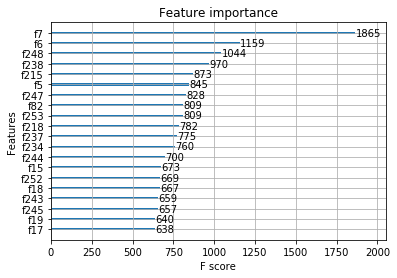

In [15]:
xgb.plot_importance(xgb_clf_precision,max_num_features=20)

# Prediction on testb dataset

In [16]:
xgb_clf_precision.predict_proba(testb_x)

predicting
precision:0.4710162503031773,recall:0.7384030418250951


d:\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
yp_pedict = clf.predict_proba(x_test)

e:\python352\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
